In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
import tensorflow
import glob
from tensorflow.keras.models import load_model
from pytictoc import TicToc 
t = TicToc()

# Camera Calibration

In [2]:
left_frame_folder = glob.glob(r'C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\17-10-23\checkerboard_17-10-23\left/*.png')
right_frame_folder = glob.glob(r'C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\17-10-23\checkerboard_17-10-23\right/*.png')
def calibrate_camera(left_frame_folder,right_frame_folder):
    left_names = left_frame_folder
    right_names = right_frame_folder
    images_left = []
    for imname in left_names:
        im = cv.imread(imname, 1)
        images_left.append(im)
    images_right = []
    for imname in right_names:
        im = cv.imread(imname, 1)
        images_right.append(im)

    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    rows = 6 #number of checkerboard rows.
    columns = 7 #number of checkerboard columns.
    world_scaling = 4.2885 #change this to the real world square size. Or not.
    
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((6 * 7, 3), np.float32)
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    objp = objp * 4.2885
    

    #frame dimensions. Frames should be the same size.
    width = images_left[0].shape[1]
    height = images_left[0].shape[0]
    
    width_r = images_right[0].shape[1]
    height_r = images_right[0].shape[0]
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []

    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space


    imcount = 1
    for frame in zip(images_left,images_right):
        gray1 = cv.cvtColor(frame[0], cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame[1], cv.COLOR_BGR2GRAY)

        
        #find the checkerboard
        ret1, corners1 = cv.findChessboardCorners(gray1, (rows, columns),  cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        ret2, corners2 = cv.findChessboardCorners(gray2, (rows, columns),  cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        if ret1 == True and ret2 == True:

            #Convolution size used to improve corner detection. Don't make this too large.
            conv_size = (11, 11)

            #opencv can attempt to improve the checkerboard coordinates
            corners1 = cv.cornerSubPix(gray1, corners1, conv_size, (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, conv_size, (-1, -1), criteria)
            img_left1 = cv.drawChessboardCorners(frame[0], (rows,columns), corners1, ret1)
            cv.imwrite(r"C:\Users\physicx\Desktop\phantom\12-10-2023_phantom_org\corner\left/"+str(imcount)+r".png", img_left1)
            img_right1 = cv.drawChessboardCorners(frame[1], (rows,columns), corners2, ret2)
            cv.imwrite(r"C:\Users\physicx\Desktop\phantom\12-10-2023_phantom_org\corner\right/"+str(imcount)+r".png", img_right1)
            imcount = imcount+1
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)


    ret1, mtx1, dist1, rvecs1, tvecs1 = cv.calibrateCamera(objpoints, imgpoints_left, (1440, 1080), None, None)
    print('rmse1:', ret1)
    print('camera matrix1:\n', mtx1)
    print('distortion coeffs1:', dist1)
    print('Rs1:\n', rvecs1)
    print('Ts1:\n', tvecs1)
    
    #reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints21, _ = cv.projectPoints(objpoints[i], rvecs1[i], tvecs1[i], mtx1, dist1)
        error = cv.norm(imgpoints_left[i], imgpoints21, cv.NORM_L2)/len(imgpoints21)
        mean_error += error
    print( "total error left frame: {}".format(mean_error/len(objpoints)))

    ret2, mtx2, dist2, rvecs2, tvecs2 = cv.calibrateCamera(objpoints, imgpoints_right, (1440, 1080), None, None)
    print('rmse2:', ret2)
    print('camera matrix2:\n', mtx2)
    print('distortion coeffs2:', dist2)
    print('Rs2:\n', rvecs2)
    print('Ts2:\n', tvecs2)
    
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints22, _ = cv.projectPoints(objpoints[i], rvecs2[i], tvecs2[i], mtx2, dist2)
        error = cv.norm(imgpoints_right[i], imgpoints22, cv.NORM_L2)/len(imgpoints22)
        mean_error += error
    print( "total error right frame: {}".format(mean_error/len(objpoints)))
#     print(imgpoints_left,imgpoints_right)
    return mtx1, dist1, mtx2, dist2,img_left1,img_right1

mtx1, dist1, mtx2, dist2, img_left1,img_right1= calibrate_camera(left_frame_folder,right_frame_folder)

rmse1: 0.5142389490444214
camera matrix1:
 [[2.38935527e+03 0.00000000e+00 7.64301370e+02]
 [0.00000000e+00 2.39080586e+03 5.09379099e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coeffs1: [[-1.22217743e-01  1.62987981e+00  4.08405293e-03 -5.66829973e-03
  -9.50646304e+00]]
Rs1:
 (array([[ 0.37577053],
       [-0.06942007],
       [-3.10487509]]), array([[-0.02138147],
       [-0.01654378],
       [-3.12841898]]), array([[ 0.77268621],
       [-0.15015272],
       [-2.99783337]]), array([[ 0.5540715 ],
       [-0.28299298],
       [-3.07881506]]), array([[ 0.21672895],
       [ 0.09141024],
       [-3.08537482]]), array([[ 0.39346132],
       [-0.08045788],
       [-1.60677518]]), array([[-1.21242175e-03],
       [-3.51326442e-02],
       [-1.58596086e+00]]), array([[ 0.36433356],
       [-0.39887464],
       [-1.50748109]]), array([[ 0.27801065],
       [ 0.02737466],
       [-1.54720637]]), array([[ 0.13064411],
       [-0.17308546],
       [-1.52006758]]), array([

# stereo calibration
to find stero calibation we need camera matrix and distortion coeffient of both camera.

In [3]:
frames_folder = r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\17-10-23\checkerboard_17-10-23\left/*"
frames_folder1 = r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\17-10-23\checkerboard_17-10-23\right/*"
def stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder,frames_folder1):
    #read the synched frames
    images_names1 = glob.glob(frames_folder)
    images_names2 = glob.glob(frames_folder1)
    c1_images_names = images_names1[0:]
    c2_images_names = images_names2[0:]
 
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv.imread(im2, 1)
        c2_images.append(_im)
 
    #change this if stereo calibration not good.
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = 6 #number of checkerboard rows.
    columns = 7 #number of checkerboard columns.
    world_scaling = 1. #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = 4.2885 * objp
 
    #frame dimensions. Frames should be the same size.
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
    
    R1=[]
    T1=[]
    
    for frame1, frame2 in zip(c1_images, c2_images):
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        
        
        c_ret1, corners1 = cv.findChessboardCorners(gray1, (rows, columns), cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        c_ret2, corners2 = cv.findChessboardCorners(gray2, (rows, columns), cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)

        if c_ret1 == True and c_ret2 == True:
            corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)

            cv.drawChessboardCorners(frame1, (rows,columns), corners1, c_ret1)
#             cv.imshow('img', frame1)

            cv.drawChessboardCorners(frame2, (rows,columns), corners2, c_ret2)
#             cv.imshow('img2', frame2)
#             cv.waitKey(0)
#             cv.destroyAllWindows()
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)

            stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
            ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)
#                 print(R)
#                 print(T)

            R1.append(R)
            T1.append(T)
#             print(R1)
#             print(T1)
#         print(ret)
    return ret,R1,T1

ret,R,T = stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder,frames_folder1)

In [4]:
print(ret)

0.8457259958920674


# AI predicted output 

In [5]:
autoencoder_vein = load_model(r"C:\Users\physicx\Desktop\phantom\02-11-2023\02-11-2023_phantom_paper\phantompaper_5-11-23.h5")
h1,  w1 = img_left1.shape[:2]
h2,  w2 = img_right1.shape[:2]


newcameramtx1, roi  = cv.getOptimalNewCameraMatrix(mtx1, dist1, (w1,h1), 1, (w1, h1))
# img_vein = cv.imread(r"C:\Users\physicx\Desktop\phantom\12-10-2023_phantom_org\data\17_10_23\Left_ph3_1710_im2.png",0)
img_vein = cv.imread(r"C:\Users\physicx\Desktop\phantom\02-11-2023\02-11-2023_phantom_paper\input1\Left_ph_21123_im7.png",0)
left_corrected = cv.undistort(img_vein,mtx1,dist1,None,newcameramtx1)
# cv.imwrite('left_corrected.png', left_corrected)
image_left_corrected = left_corrected.reshape((1,1080, 1440,1)).astype('float32') / 255.
prediected_left = autoencoder_vein.predict(image_left_corrected)
prediected_left = (prediected_left.reshape((1080, 1440)) * 255 ).astype('uint8')
# cv.imwrite("prediected_left.png",prediected_left)
 
# clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize=(5,5))
# cl_img1 = clahe.apply(left_corrected)

newcameramtx2, roi = cv.getOptimalNewCameraMatrix(mtx2, dist2, (w2,h2), 1, (w2,h2))
# img_vein1 = cv.imread(r"C:\Users\physicx\Desktop\phantom\12-10-2023_phantom_org\data\17_10_23\Right_ph3_1710_im2.png",0)
img_vein1 = cv.imread(r"C:\Users\physicx\Desktop\phantom\02-11-2023\02-11-2023_phantom_paper\input1\Right_ph_21123_im7.png",0)
right_corrected = cv.undistort(img_vein1,mtx2,dist2,None,newcameramtx2)
# cv.imwrite('Right_corrected.png', right_corrected)
image_right_corrected = right_corrected.reshape((1,1080, 1440,1)).astype('float32') / 255.
prediected_right = autoencoder_vein.predict(image_right_corrected)
prediected_right = (prediected_right.reshape((1080, 1440)) * 255 ).astype('uint8')
# cv.imwrite("prediected_right.png",prediected_right)

# cl_img2 = clahe.apply(right_corrected)

1/1 [==============================] - 1s 601ms/step


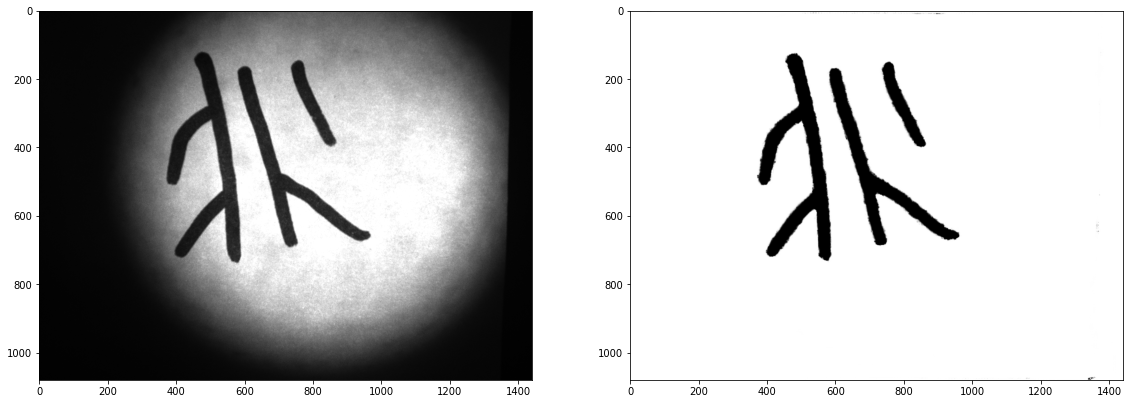

In [6]:
plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)
plt.imshow(img_vein,cmap='gray')
# cv.imwrite("left_corrected.png",thresh1)
# target image

ax = plt.subplot(1,3,2)
plt.imshow(prediected_left,cmap='gray')
# cv.imwrite("thresh2.png",thresh2)

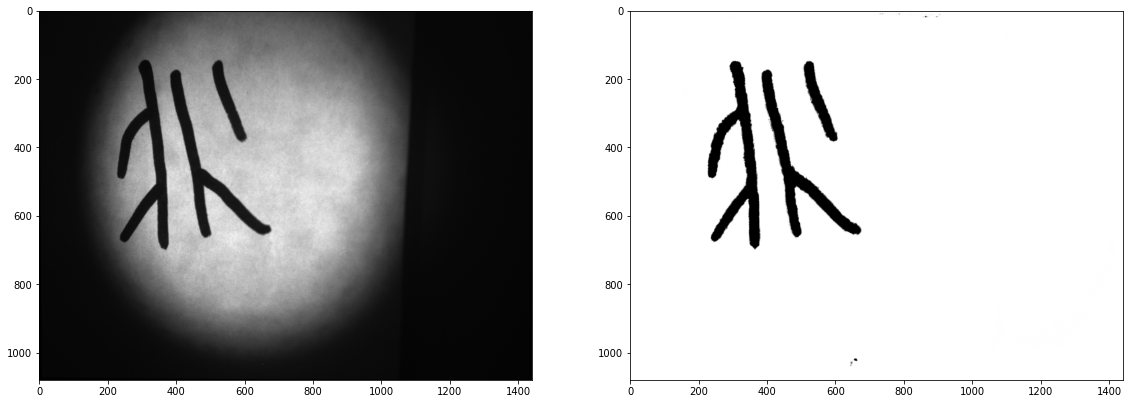

In [7]:
plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)
plt.imshow(right_corrected,cmap='gray')
# cv.imwrite("left_corrected.png",thresh1)
# target image

ax = plt.subplot(1,3,2)
plt.imshow(prediected_right,cmap='gray')
# cv.imwrite("thresh2.png",thresh2)

# post-processing
To overcome Noise in AI predicted output

In [8]:
thresh1 = cv.GaussianBlur(prediected_left,(25,25),0)
thresh2 = cv.GaussianBlur(prediected_right,(25,25),0)

In [9]:
thresh1 = cv.adaptiveThreshold(thresh1, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
thresh2 = cv.adaptiveThreshold(thresh2, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)

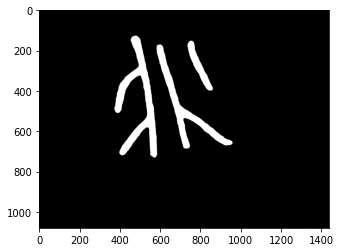

In [10]:
plt.imshow(thresh1,cmap='gray')
# cv.imwrite("thresh_left.png",thresh1)

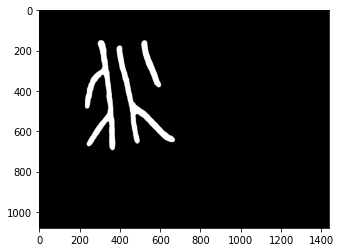

In [11]:
plt.imshow(thresh2,cmap='gray')
# cv.imwrite("thresh_right.png",thresh2)

# Skeletonization
To get better keypoint matching, we tried to sketenize image.

In [12]:
# import cv2
# img = thresh1
# size = np.size(img)
# skel = np.zeros(img.shape,np.uint8)

# # s = time()
# ret,img = cv2.threshold(img,127,255,0)
# element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
# done = False


# while( not done):
#     eroded = cv2.erode(img,element)
#     temp = cv2.dilate(eroded,element)
#     temp = cv2.subtract(img,temp)
#     skel = cv2.bitwise_or(skel,temp)
#     img = eroded.copy()

#     zeros = size - cv2.countNonZero(img)
#     if zeros==size:
#         done = True       
# frame_l = skel

# img = thresh2
# size = np.size(img)
# skel = np.zeros(img.shape,np.uint8)
# done = False

# while( not done):
#     eroded = cv2.erode(img,element)
#     temp = cv2.dilate(eroded,element)
#     temp = cv2.subtract(img,temp)
#     skel = cv2.bitwise_or(skel,temp)
#     img = eroded.copy()

#     zeros = size - cv2.countNonZero(img)
#     if zeros==size:
#         done = True

# # print(time()-s)

# frame_r= skel

# Key-point matching

In [13]:
scale = 1
widthl = int(thresh1.shape[1]/scale)
heightl = int(thresh1.shape[0]/scale)
diml = (widthl, heightl)
img1 = cv.resize(thresh1, diml, cv.INTER_AREA)

widthr = int(thresh2.shape[1]/scale)
heightr = int(thresh2.shape[0]/scale)
dimr = (widthr, heightr)
img2 = cv.resize(thresh2, dimr, cv.INTER_AREA)

#ORB algorithm 
orb = cv.ORB_create(nfeatures = 1500, edgeThreshold = 180, patchSize = 180, WTA_K = 4)
KeyPoints1, des1 = orb.detectAndCompute(img1, None)
KeyPoints2, des2 = orb.detectAndCompute(img2, None)

In [14]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck= True)
matches = bf.match(des1, des2)
len(matches)


matches = sorted(matches, key = lambda x:x.distance)

matchCoordinatesL_1=[]
matchCoordinatesR_1=[]
for match in matches:
    matchCoordinatesL_1.append([KeyPoints1[match.queryIdx].pt])
    matchCoordinatesR_1.append([KeyPoints2[match.trainIdx].pt])

# After getting matched keypoints, remove wrong matched keypoints using z_h and z_w 
# z_h= hight difference between left and right image and 
# z_w = width difference between left and right images.
good_matches1=[]
matchCoordinatesL_2 = []
matchCoordinatesR_2 = []
for i in range(len(matchCoordinatesL_1)):
    x = matchCoordinatesL_1[i]
    y = matchCoordinatesR_1[i]
    z_h = abs(x[0][1] - y[0][1])
    z_w = abs(x[0][0] - y[0][0])
    if z_h <=50 and z_h>=2: 
        matchCoordinatesL_2.append(x)
        matchCoordinatesR_2.append(y)
        good_matches1.append(matches[i])
    else:
        pass

In [15]:
len(matchCoordinatesL_2),len(matchCoordinatesR_2)

(146, 146)

In [16]:
import cv2
matching_result = cv2.drawMatches(img1, KeyPoints1, img2, KeyPoints2, good_matches1, None, flags=2)

matchCoordinatesL = np.array(matchCoordinatesL_2)
matchCoordinatesR = np.array(matchCoordinatesR_2)

matchCoordinatesL = matchCoordinatesL.reshape(matchCoordinatesL.shape[0],2)*scale
matchCoordinatesR = matchCoordinatesR.reshape(matchCoordinatesR.shape[0],2)*scale

matchCoordinates = np.vstack((matchCoordinatesL, matchCoordinatesR))
matchCoordinates = matchCoordinates.reshape((2, matchCoordinatesL.shape[0], matchCoordinatesL.shape[1]))

In [17]:
len(good_matches1)

146

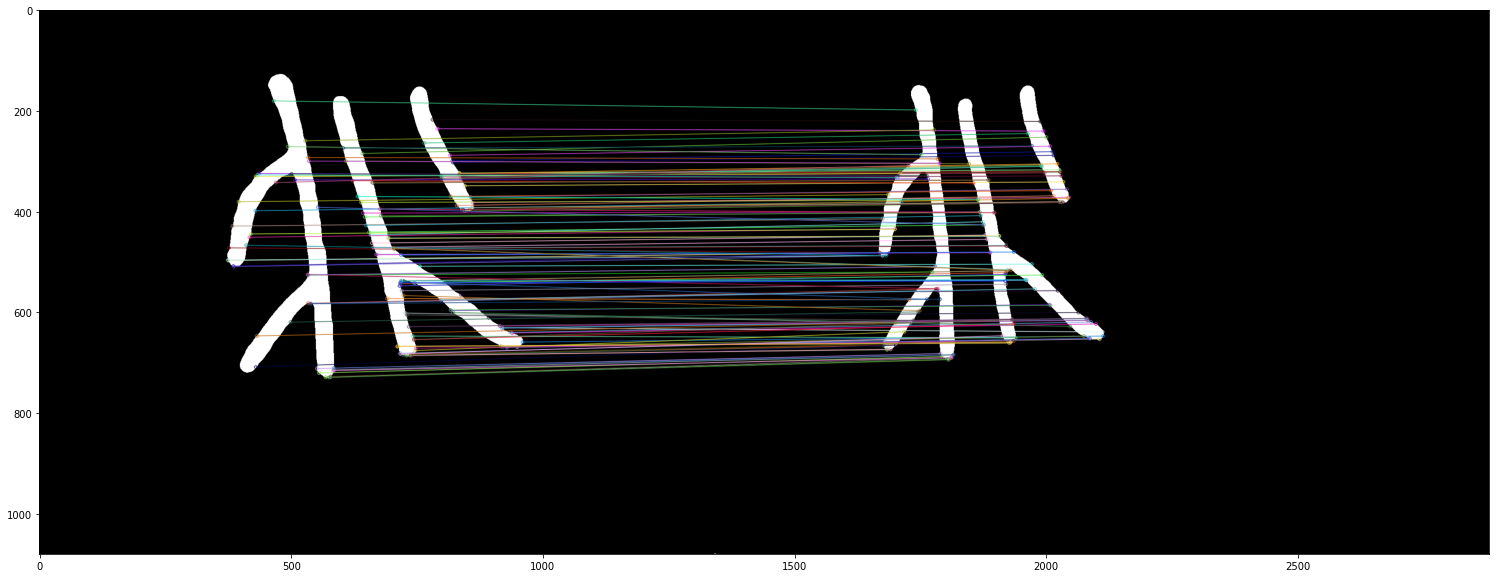

In [18]:
matching_result = cv2.drawMatches(img1, KeyPoints1, img2, KeyPoints2, good_matches1, None, flags=2)
plt.figure(figsize=(30,10))
plt.imshow(matching_result,cmap = 'gray')
# plt.savefig("keypoints.png")

# Homography 
It is used to get approximated orientation of left image with respect to right image or vice versa.

In [19]:
matchCoordinatesL = matchCoordinates[0,:,:]
matchCoordinatesR = matchCoordinates[1,:,:]
# Homography
h,status = cv2.findHomography(matchCoordinatesL, matchCoordinatesR, cv2.RANSAC, ransacReprojThreshold = 100, maxIters = 15, confidence = 0.999)

In [20]:
warped_frame_l = cv2.warpPerspective(thresh1, h, (thresh1.shape[1],thresh1.shape[0]))

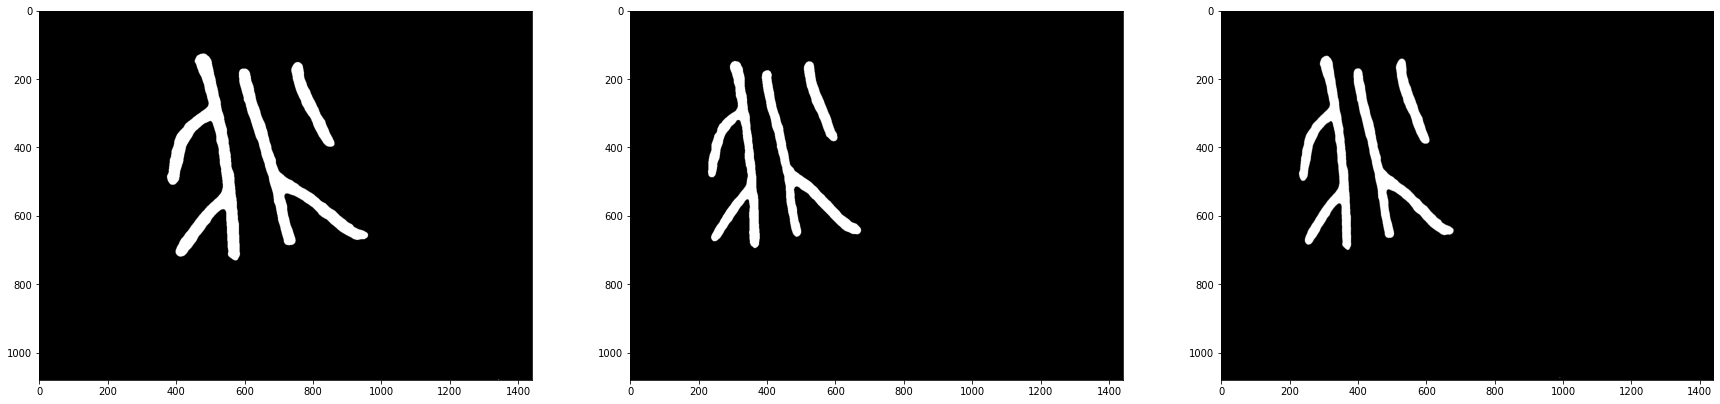

In [21]:
plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)
plt.imshow(thresh1,cmap='gray')
# cv.imwrite("left_corrected.png",thresh1)
# target image

ax = plt.subplot(1,3,2)
plt.imshow(thresh2,cmap='gray')
# cv.imwrite("thresh2.png",thresh2)
ax = plt.subplot(1,3,3)
plt.imshow(warped_frame_l,cmap='gray')
# cv.imwrite("left_reconstrusted.png",im_out)

In [22]:
# Overlap left image with right corrected image using homography
dst = cv.addWeighted(thresh2, 0.4, warped_frame_l, 0.6, 0)

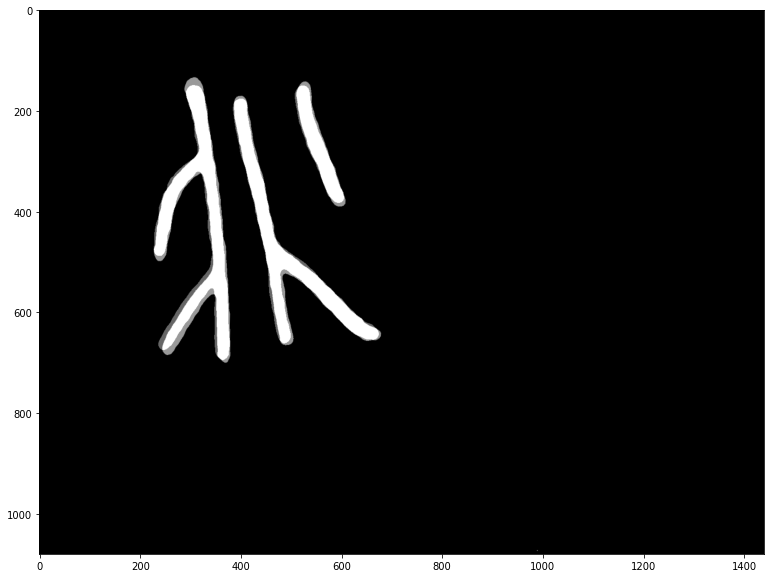

In [23]:
plt.figure(figsize=(30,10))
plt.imshow(dst,cmap = 'gray')
# plt.savefig("homography.png")

# Finding Signal points 

In [24]:
a = np.where((thresh1==255))
pa = []
for i in range(len(a[0])):
    p32 = (a[0][i],a[1][i])
#     print(p32)
    pa.append(p32)
pa = np.array(pa)


pa_h = []
for i in range(len(a[0])):
    pa_h32 = np.dot(h,(a[0][i],a[1][i], 1))
    pa_h32 = (pa_h32[0],pa_h32[1])
#     print(pa_h32)
    pa_h.append(pa_h32)
pa_h = np.asarray(pa_h)

In [25]:
pa_h.shape,pa.shape

((74773, 2), (74773, 2))

# Finding Projection matrix 

In [26]:
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx1 @ RT1 #projection matrix for C1
   
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R[6], T[6]], axis = -1)
P2 = mtx2 @ RT2 #projection matrix for C2

In [27]:
P1,P2

(array([[2.38935527e+03, 0.00000000e+00, 7.64301370e+02, 0.00000000e+00],
        [0.00000000e+00, 2.39080586e+03, 5.09379099e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.35711490e+03,  1.37161411e+01,  1.85129258e+03,
         -2.12438015e+05],
        [-2.44404396e+02,  2.11708183e+03,  4.29916856e+02,
          2.69973622e+03],
        [-5.14169364e-01,  2.84808568e-02,  8.57215671e-01,
          1.04520932e+01]]))

# DLT (Diect linear Transform Algorithm)

In [28]:
import tensorflow as tf
@tf.function
def DLT_vectorized(P1, P2, points1, points2):
    
    A = tf.stack([
        tf.experimental.numpy.outer(points1[:, 1],P1[2, :]) - P1[1, :],
        P1[0, :] - tf.experimental.numpy.outer(points1[:, 0], P1[2, :]),
        tf.experimental.numpy.outer(points2[:, 1], P2[2, :]) - P2[1, :],
        P2[0, :] - tf.experimental.numpy.outer(points2[:, 0],P2[2, :])
    ])
    
    A = tf.transpose(A, (1,0,2))
    
    U, s, Vh = tf.linalg.svd(A, full_matrices = False)
    t = tf.reshape(Vh[:, 3, 3],(1,-1, 1))
    p3ds = Vh[:, 0:3, 3]/t
    p3ds = tf.reshape(p3ds, (-1, 3))
    
    return p3ds

In [29]:
t.tic()
p3ds = DLT_vectorized(P1, P2, pa, pa_h)
t.toc()
p3ds = p3ds.numpy()
p3ds

Elapsed time is 1.110502 seconds.


array([[-39.80306301,  -1.23846671, 149.19944156],
       [-39.80339914,  -1.17238355, 149.20116235],
       [-39.80373375,  -1.10629821, 149.20288256],
       ...,
       [ 19.27460341,  49.35575548, 149.91004279],
       [ 19.33465643,  49.34427227, 149.89559795],
       [ 19.33419367,  49.40624911, 149.89821282]])

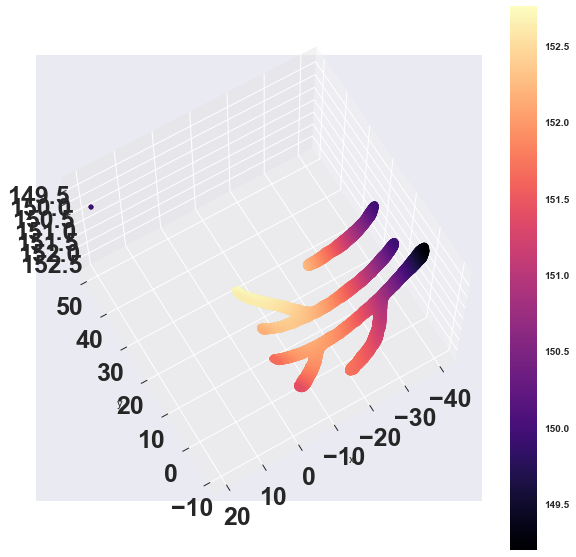

In [30]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
mpl.style.use('seaborn')

 
fig = plt.figure(figsize=(10,10))
np.random.seed(11)


ax = fig.add_subplot(111, projection='3d')

c = p3ds[0:,[2]] 
rcParams['font.weight'] = 'bold'
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(25)
        tick.label.set_fontweight('bold')
        
       
p=ax.scatter(p3ds[0:,[0]],p3ds[0:,[1]],p3ds[0:,[2]],c = c, cmap=plt.cm.magma)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

elev = 245.25
azim = 120.5
ax.view_init(elev, azim)


fig.colorbar(p, ax=ax)

fig.savefig("scatter_view_color_bar_input4 (26).png")
plt.show()

# print('ax.azim {}'.format(ax.azim))
# print('ax.elev {}'.format(ax.elev))

# ax.view_init(elev, azim)